### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempPropSelection/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 143 ms, sys: 67.3 ms, total: 210 ms
Wall time: 228 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
#treated[treated.PERS_ID == '2567120'][['MYR', 'ALLOW_IP', 'ALLOW_ER', 'Acute-bin']]

In [10]:
#survTr

In [11]:
%%time
after = 1
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)


CPU times: user 3.5 s, sys: 29.1 ms, total: 3.53 s
Wall time: 3.53 s


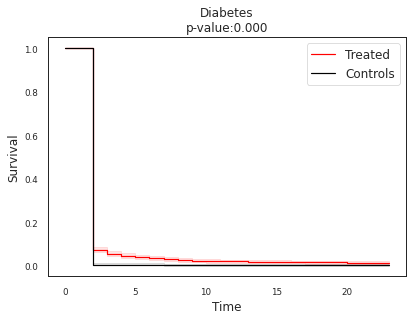

In [12]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [13]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       31.173062  2.360187e-08  25.336524

In [14]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.303           0.164       -1.849    0.064
Gender               0.016           0.043        0.364    0.716
Total Cost           0.006           0.010        0.671    0.503
Tobacco use         -0.013           0.064       -0.209    0.834
Obesity             -0.027           0.049       -0.542    0.587
Hypertension         0.090           0.052        1.724    0.085
Hypothyroid         -0.061           0.074       -0.826    0.409
Disease Count        1.037           0.217        4.776    0.000
Treatment           -0.240           0.048       -5.009    0.000

### ER

In [15]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.43 s, sys: 34.9 ms, total: 3.47 s
Wall time: 3.47 s


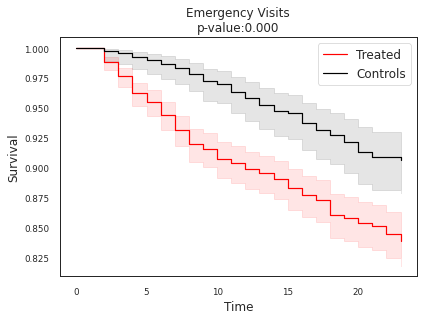

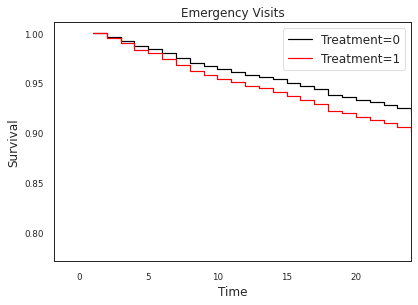

In [17]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [18]:
lrsumm

test_statistic         p   -log2(p)
Emergency Visits       20.447036  0.000006  17.315577

In [19]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -2.387           0.375       -6.366    0.000
Gender              -0.432           0.102       -4.245    0.000
Total Cost           0.102           0.026        3.877    0.000
Tobacco use          0.522           0.121        4.312    0.000
Obesity             -0.371           0.112       -3.326    0.001
Hypertension        -0.070           0.121       -0.578    0.564
Hypothyroid         -0.106           0.154       -0.689    0.491
Disease Count        3.845           0.482        7.979    0.000
Treatment            0.239           0.121        1.976    0.048

### IP

In [20]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.42 s, sys: 19.3 ms, total: 3.43 s
Wall time: 3.43 s


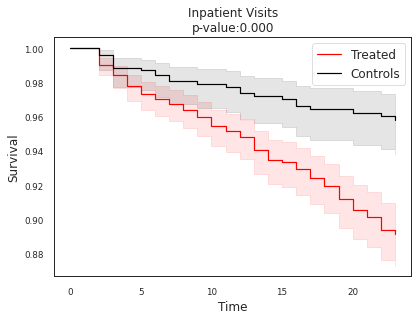

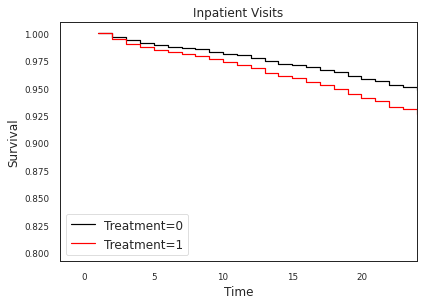

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [23]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits        17.01112  0.000037  14.71583

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                  0.500           0.520        0.962    0.336
Gender               0.132           0.123        1.080    0.280
Total Cost           0.273           0.039        6.923    0.000
Tobacco use          0.387           0.151        2.560    0.010
Obesity             -0.303           0.134       -2.271    0.023
Hypertension        -0.148           0.151       -0.981    0.327
Hypothyroid         -0.228           0.181       -1.261    0.207
Disease Count        4.664           0.511        9.129    0.000
Treatment            0.355           0.153        2.327    0.020

### Acute Care IP OR ER

In [25]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.41 s, sys: 5.12 ms, total: 3.42 s
Wall time: 3.41 s


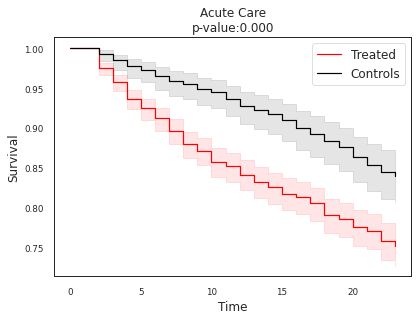

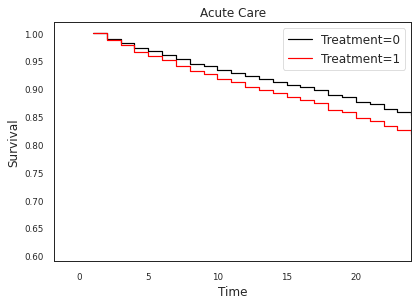

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [28]:
lrsumm

test_statistic             p   -log2(p)
Acute Care       27.439962  1.620478e-07  22.557077

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.343           0.319       -4.204    0.000
Gender              -0.149           0.080       -1.859    0.063
Total Cost           0.155           0.023        6.889    0.000
Tobacco use          0.516           0.100        5.175    0.000
Obesity             -0.290           0.090       -3.234    0.001
Hypertension        -0.120           0.097       -1.229    0.219
Hypothyroid         -0.238           0.127       -1.873    0.061
Disease Count        4.160           0.383       10.855    0.000
Treatment            0.225           0.096        2.335    0.020

### Load all Log Rank Sums in a matrix

In [30]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [31]:
df2

logRank statistic       p-value  RMST difference
Diabetes                  31.173062  2.360187e-08         0.488995
Emergency Visits          20.447036  6.130443e-06        -1.160633
Inpatient Vistis          17.011120  3.716154e-05        -0.706628
Acute Care                27.439962  1.620478e-07        -1.632296